<a href="https://colab.research.google.com/github/rsadaphule/jhu-aaml/blob/main/Module02_XAI_sadaphule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommender Systems
# JHU Course EN.705742.8VL.FA23
## Student: Ravindra Sadaphule

### Notes
* This notebook runs on Google Colab ENvironement
* All data  files are read from Google Drive rom path TRAIN_FILE_FOLDER
* The notebook ran on GPU A100 with high RAM

In [1]:
from google.colab import drive; drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
from IPython.display import display
import numpy as np
import pandas as pd
import sys
import sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
# import warnings
import warnings
from sklearn.exceptions import ConvergenceWarning

from warnings import simplefilter
simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
TRAIN_FILE_FOLDER = '/content/drive/My Drive/JHU/AAML/Assignments/data/'


In [4]:
def bc_preprocess(_df):
    # Check if we have any '?' in df values
    print(_df.columns[_df.isin(['?']).any()])
    # Check if we have any NaN in df values
    print(_df.columns[_df.isnull().any()])
    # Drop the rows with '?'
    _df = _df[~_df['node-caps'].isin(['?']) & ~_df['breast-quad'].isin(['?'])]
    # See how many rows we lost
    print(f'#rows= {len(_df)} #columns= {len(_df.columns)}')
    _df.reset_index(inplace=True, drop=True)  # required after row deletion
    return _df

# Load data
df = pd.read_csv(TRAIN_FILE_FOLDER + 'breast_cancer_preprocessed.csv')

# Sanity check
print(f'#rows= {len(df)} #columns= {len(df.columns)}')
df.head()

#rows= 286 #columns= 10


age menopause  tumor-size  inv-nodes node-caps  deg-malig breast  \
0   44   premeno          18          0       yes          3  right   
1   58      ge40          18          1        no          1  right   
2   51      ge40          39          0        no          2   left   
3   49   premeno          35          1       yes          3  right   
4   41   premeno          32          5       yes          2   left   

  breast-quad irradiat            recurrence  
0     left_up       no     recurrence-events  
1     central       no  no-recurrence-events  
2    left_low       no     recurrence-events  
3    left_low      yes  no-recurrence-events  
4    right_up       no     recurrence-events

In [5]:
df = bc_preprocess(df)

Index(['node-caps', 'breast-quad'], dtype='object')
Index([], dtype='object')
#rows= 277 #columns= 10


In [6]:
# feature exploration
print(df['menopause'].unique())
print(df['node-caps'].unique())
print(df['breast'].unique())
print(df['breast-quad'].unique())
print(df['irradiat'].unique())

['premeno' 'ge40' 'lt40']
['yes' 'no']
['right' 'left']
['left_up' 'central' 'left_low' 'right_up' 'right_low']
['no' 'yes']


In [7]:
# treat binary variables as 0 and 1
df['node-caps'] = df['node-caps'].replace({'no':0, 'yes':1})
df['irradiat'] = df['irradiat'].replace({'no':0, 'yes':1})

In [8]:
df.head()

age menopause  tumor-size  inv-nodes  node-caps  deg-malig breast  \
0   44   premeno          18          0          1          3  right   
1   58      ge40          18          1          0          1  right   
2   51      ge40          39          0          0          2   left   
3   49   premeno          35          1          1          3  right   
4   41   premeno          32          5          1          2   left   

  breast-quad  irradiat            recurrence  
0     left_up         0     recurrence-events  
1     central         0  no-recurrence-events  
2    left_low         0     recurrence-events  
3    left_low         1  no-recurrence-events  
4    right_up         0     recurrence-events

In [9]:
def encode_onehot (_df, _f_target):
    ___df = _df.copy()
    # Convert all features of type object to one-hot encoded with pandas dummies
    for f in list(_df.columns.values):
        if _df[f].dtype == object:
            if f != _f_target:  # recurrence is the target variable and will be treated differently
                __df = pd.get_dummies(_df[f], prefix='',
                                      prefix_sep='').groupby(level=0, axis=1).max().add_prefix(f+' - ')
                _df = pd.concat([_df, __df], axis=1)
                _df = _df.drop([f], axis=1)
    return _df

# Convert the variable recurrence to numerical
df = encode_onehot(df, 'recurrence')

# Sanity check
df.head()

age  tumor-size  inv-nodes  node-caps  deg-malig  irradiat  \
0   44          18          0          1          3         0   
1   58          18          1          0          1         0   
2   51          39          0          0          2         0   
3   49          35          1          1          3         1   
4   41          32          5          1          2         0   

             recurrence  menopause - ge40  menopause - lt40  \
0     recurrence-events                 0                 0   
1  no-recurrence-events                 1                 0   
2     recurrence-events                 1                 0   
3  no-recurrence-events                 0                 0   
4     recurrence-events                 0                 0   

   menopause - premeno  breast - left  breast - right  breast-quad - central  \
0                    1              0               1                      0   
1                    0              0               1                      1   
2                    0              1               0                      0   
3                    1              0               1                      0   
4                    1              1               0                      0   

   breast-quad - left_low  breast-quad - left_up  breast-quad - right_low  \
0                       0                      1                        0   
1                       0                      0                        0   
2                       1                      0                        0   
3                       1                      0                        0   
4                       0                      0                        0   

   breast-quad - right_up  
0                       0  
1                       0  
2                       0  
3                       0  
4                       1

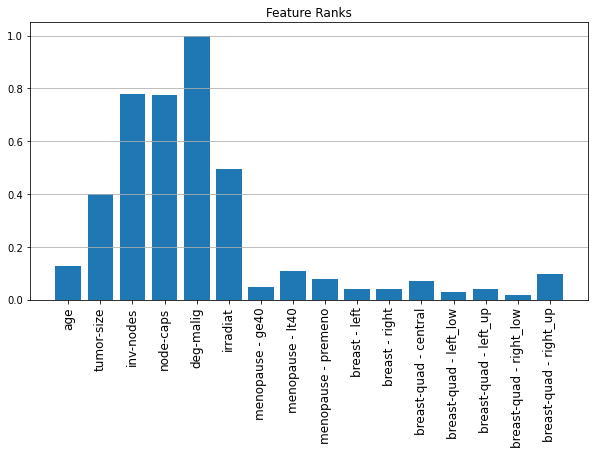

In [10]:
from sklearn.feature_selection import SelectPercentile, f_classif

X = df.loc[:, df.columns != 'recurrence'].values
y = df.loc[:, df.columns == 'recurrence'].values.ravel()

selector = SelectPercentile(f_classif, percentile=10)
# Fit the data
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

# Display
plt.figure(figsize=(10,5), dpi=72)
cols = [_ for _ in df.columns if _ != 'recurrence']
y_pos = np.arange(len(cols))
plt.bar(y_pos, scores)
plt.xticks(y_pos, cols, rotation=90, fontsize=12)
plt.grid(axis='y')
plt.title('Feature Ranks')
plt.show()

In [11]:
# Build a model
clf_lr = LogisticRegression(random_state=0, solver='sag', max_iter=10000).fit(X, y)

In [12]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f20da1bd07e7fcf0702b58e7ae257c8ca76d6d057a221ff854e07018bbfaacaf
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [13]:
from lime.lime_tabular import LimeTabularExplainer
from lime.lime_text import LimeTextExplainer

In [14]:
explainer = LimeTabularExplainer(X, mode='classification',
                                 feature_names=cols, class_names=df['recurrence'].unique().tolist(),
                                 categorical_features=None)

In [15]:
D_ID = 0
N_FEATURES= 7

exp = explainer.explain_instance(X[D_ID], clf_lr.predict_proba, num_features=N_FEATURES)

In [16]:
exp.show_in_notebook(show_table=True)

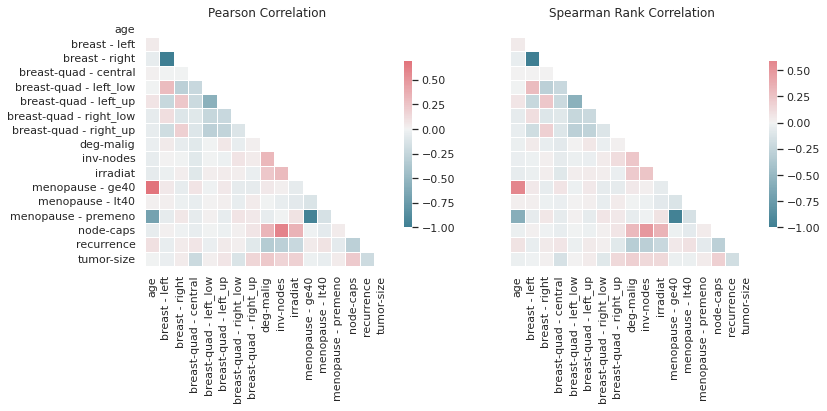

In [17]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# attempt correlation, need numericals
df_ = df.copy()
df_['recurrence'].replace({'recurrence-events':0, 'no-recurrence-events':1}, inplace=True)
df_ = df_[sorted(df_.columns)]  # explanation requires some order

# Check variable correlations to infer about strong features
corr_df1, corr_df2 = df_.corr(method='pearson'), df_.corr(method='kendall')

# Draw a lower triangle matrix since correlation is symmetrical
mask1, mask2 = np.zeros_like(corr_df1, dtype=bool), np.zeros_like(corr_df2, dtype=bool)
mask1[np.triu_indices_from(mask1)], mask2[np.triu_indices_from(mask2)] = True, True

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.set(style="white")

_, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 12), dpi=72)
ax = ax.flatten()
sns.heatmap(corr_df1, ax=ax[0], mask=mask1, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .25})
ax[0].set_title('Pearson Correlation')
sns.heatmap(corr_df2, ax=ax[1], mask=mask2, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .25})
ax[1].set_title('Spearman Rank Correlation')
plt.show()

In [18]:
# explore hyperparameter space
def run_classifier(_clf, _X, _y):
    tpr, fpr, acc = [], [], []
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    for tr_i, ts_i in kf.split(_X, _y):
        _clf.fit(_X[tr_i], _y[tr_i])
        y_pred = _clf.predict(_X[ts_i])
        acc += [accuracy_score(_y[ts_i], y_pred)]
        tn, fp, fn, tp = confusion_matrix(_y[ts_i], y_pred, labels=[1,0]).ravel()
        tpr += [tp/(tp+fn)]  # Probability
        fpr += [fp/(fp+tn)]  # False alarm
    return np.array(acc), np.mean(tpr), np.mean(fpr)

def run_params_logisticregression(_X, _y):
    Tpr, Fpr, Acc, Std = [], [], [], []
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        for solv in ('lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'):
            for invreg_c in (2e-1, 0.5, 0.8, 1, 2, 5, 1e1, 2e1, 1e2):
                clf = LogisticRegression(C=invreg_c, solver=solv, random_state=0, max_iter=3000)
                acc, tpr, fpr = run_classifier(clf, _X, _y)
                acc, std = np.mean(acc), np.std(acc)
                Acc += [acc]; Std += [std]; Tpr += [tpr]; Fpr += [fpr]
                # debug
                sys.stderr.write(f"\r LR acc={acc:.2f} {chr(177)}{std:.3f}"); sys.stderr.flush()
    return Tpr, Fpr, Acc, np.array(Std)

def run_params_randomforest(_X, _y):
    Tpr, Fpr, Acc, Std = [], [], [], []
    for ne in np.linspace(20,100, num=3, dtype=int):
        for md in np.linspace(2,8, num=3, dtype=int):
            for mf in np.linspace(3,20, num=3, dtype=int):
                clf = RandomForestClassifier(n_estimators=ne, max_depth=md, max_features=mf, n_jobs=-1)
                acc, tpr, fpr = run_classifier(clf, _X, _y)
                acc, std = np.mean(acc), np.std(acc)
                Acc += [acc]; Std += [std]; Tpr += [tpr]; Fpr += [fpr]
                # debug
                sys.stderr.write(f"\r RF acc={acc:.2f} {chr(177)}{std:.3f}"); sys.stderr.flush()
    return Tpr, Fpr, Acc, np.array(Std)

def run_params_gradientboosting(_X, _y):
    Tpr, Fpr, Acc, Std = [], [], [], []
    for ne in np.linspace(10,100, num=5, dtype=int):
        clf = GradientBoostingClassifier(n_estimators=ne)
        acc, tpr, fpr = run_classifier(clf, _X, _y)
        acc, std = np.mean(acc), np.std(acc)
        Acc += [acc]; Std += [std]; Tpr += [tpr]; Fpr += [fpr]
        # debug
        sys.stderr.write(f"\r GB acc={acc:.2f} {chr(177)}{std:.3f}"); sys.stderr.flush()
    return Tpr, Fpr, Acc, np.array(Std)


X = df_.loc[:, df_.columns != 'recurrence'].values
y = df_.loc[:, df_.columns == 'recurrence'].values.ravel()

Tpr1, Fpr1, Acc1, Std1 = run_params_logisticregression(X, y)
Tpr2, Fpr2, Acc2, Std2 = run_params_randomforest(X, y)
Tpr3, Fpr3, Acc3, Std3 = run_params_gradientboosting(X, y)


 GB acc=0.72 ±0.075

In [19]:
# Size of the marker shows the error variance
COEF = 100
Std10 = (COEF*np.array(Std1))**2
Std20 = (COEF*np.array(Std2))**2
Std30 = (COEF*np.array(Std3))**2

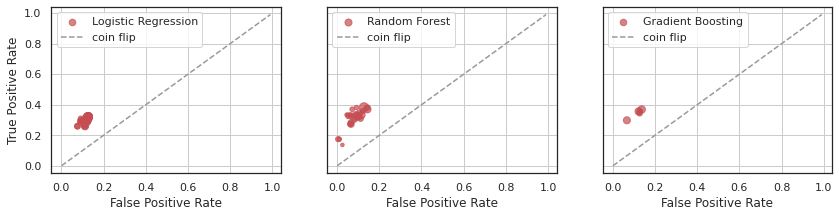

In [20]:
def diagonal(_ax):
    _ax.plot(np.arange(0.001,1,0.01), np.arange(0.001,1,0.01), linestyle='--', color=(0.6, 0.6, 0.6), label='coin flip')

_, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(14, 3), dpi=72)
ax = ax.flatten()

ax[0].scatter(Fpr1, Tpr1, s=Std10, marker='o', c='r', label='Logistic Regression', alpha=0.7)
diagonal(ax[0])
ax[0].set_ylabel('True Positive Rate')
ax[0].set_xlabel('False Positive Rate')
ax[0].legend()
ax[0].grid()

ax[1].scatter(Fpr2, Tpr2, s=Std20, marker='o', c='r', label='Random Forest', alpha=0.7)
diagonal(ax[1])
ax[1].set_xlabel('False Positive Rate')
ax[1].legend()
ax[1].grid()

ax[2].scatter(Fpr3, Tpr3, s=Std30, marker='o', c='r', label='Gradient Boosting', alpha=0.7)
diagonal(ax[2])
ax[2].set_xlabel('False Positive Rate')
ax[2].legend()
ax[2].grid()

plt.show()

# Example Text Classification

The 20 newsgroups dataset comprises around 18k newsgroups posts on 20 topics split in two subsets of training and testing. Let's build a model and differentiate between predictions with respect to features, in this case specific words from the vocabulary.

In [22]:
from sklearn.datasets import fetch_20newsgroups

# Explore the dataset
print(fetch_20newsgroups()['target_names'])

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [23]:
# Select two classes for the lecture
Categories = ['rec.motorcycles', 'misc.forsale']

In [24]:
# Build a model
ng_train = fetch_20newsgroups(subset='train', categories=Categories)
ng_test = fetch_20newsgroups(subset='test', categories=Categories)

vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False,  # stop_words='english',
                                                             max_features=3000, dtype=np.float32)
X_train = vectorizer.fit_transform(ng_train.data)
X_test = vectorizer.transform(ng_test.data)

In [25]:
svc = SVC(kernel='linear', probability=True).fit(X_train, ng_train.target)
print(f'Linear SVC accuracy={accuracy_score(ng_test.target, svc.predict(X_test)):.2f}')

Linear SVC accuracy=0.98


In [26]:
rf = RandomForestClassifier(n_estimators=500).fit(X_train, ng_train.target)
print(f'RF accuracy={accuracy_score(ng_test.target, rf.predict(X_test)):.2f}')

RF accuracy=0.96


In [27]:
c1 = make_pipeline(vectorizer, svc)
print(c1.predict_proba([ng_test.data[0]]))

explainer1 = LimeTextExplainer(class_names=Categories)

[[0.07511138 0.92488862]]


In [28]:
c2 = make_pipeline(vectorizer, rf)
print(c2.predict_proba([ng_test.data[0]]))

explainer2 = LimeTextExplainer(class_names=Categories)

[[0.238 0.762]]


In [29]:
DOC_ID= 42
N_FEATURES= 7

# Explain features helped this document to be classified
exp1 = explainer1.explain_instance(ng_test.data[DOC_ID], c1.predict_proba, num_features=N_FEATURES)
print(f'Document id= {DOC_ID}')
print(f'True class= {Categories[ng_test.target[DOC_ID]]}')
print()
print(f'LinearSVC Prob {Categories[1]} =, {c1.predict_proba([ng_test.data[DOC_ID]])[0,1]:.3f}')
print(', '.join([f"{w} {s:.3f}" for w,s in exp1.as_list()]))

#print(f'[w+s%.2f for w,s in exp2.as_list()]')

exp2 = explainer2.explain_instance(ng_test.data[DOC_ID], c2.predict_proba, num_features=N_FEATURES)
print()
print(f'RF Prob {Categories[1]} =, {c2.predict_proba([ng_test.data[DOC_ID]])[0,1]:.3f}')
print(', '.join([f"{w} {s:.3f}" for w,s in exp2.as_list()]))

Document id= 42
True class= misc.forsale

LinearSVC Prob misc.forsale =, 0.994
Winona 0.067, Stafford 0.065, do 0.034, Re 0.030, shaft 0.027, All -0.013, are -0.013

RF Prob misc.forsale =, 0.772
Re 0.132, article 0.120, In 0.085, do 0.066, what 0.041, wrote 0.040, but 0.035


In [30]:
exp1.show_in_notebook(text=True)

In [31]:
exp2.show_in_notebook(text=True)

In [32]:
# Explain features helped this document to be classified, effect when removed first two features
print(f'Original SVC prediction= {svc.predict_proba(X_test[DOC_ID])[0,1]:.3f}')
tmp = X_test[DOC_ID].copy()
tmp[0,vectorizer.vocabulary_[exp1.as_list()[0][0]]] = 0
tmp[0,vectorizer.vocabulary_[exp1.as_list()[1][0]]] = 0
print(f'Prob after removing feats ({exp1.as_list()[0][0]} {exp1.as_list()[1][0]})= {svc.predict_proba(tmp)[0,1]:.3f}')
print(f'Difference= {svc.predict_proba(X_test[DOC_ID])[0,1]-svc.predict_proba(tmp)[0,1]:.3f}')
print()
print(f'Original RF prediction= {rf.predict_proba(X_test[DOC_ID])[0,1]:.3f}')
tmp = X_test[DOC_ID].copy()
tmp[0,vectorizer.vocabulary_[exp2.as_list()[0][0]]] = 0
tmp[0,vectorizer.vocabulary_[exp2.as_list()[1][0]]] = 0
print(f'Prob after removing feats ({exp2.as_list()[0][0]} {exp2.as_list()[1][0]})= {rf.predict_proba(tmp)[0,1]:.3f}')
print(f'Difference= {rf.predict_proba(X_test[DOC_ID])[0,1]-rf.predict_proba(tmp)[0,1]:.3f}')

Original SVC prediction= 0.994
Prob after removing feats (Winona Stafford)= 0.926
Difference= 0.068

Original RF prediction= 0.772
Prob after removing feats (Re article)= 0.570
Difference= 0.202


Exercises
Exercise 1. Find out if the LIME results support the LR feature ranking in the breast cancer problem.

 To compare the global feature importance from Logistic Regression (LR) with the local explanations from LIME, we can aggregate LIME's importance scores across multiple instances and then compare this aggregated importance with the coefficients from LR.


Aggregate LIME's Importance Scores:

For each instance in the dataset, generate LIME explanations.
Aggregate the importance scores for each feature.
Compare with LR Coefficients:

Normalize both the aggregated LIME scores and LR coefficients to make them comparable.

Check to see if the score align.



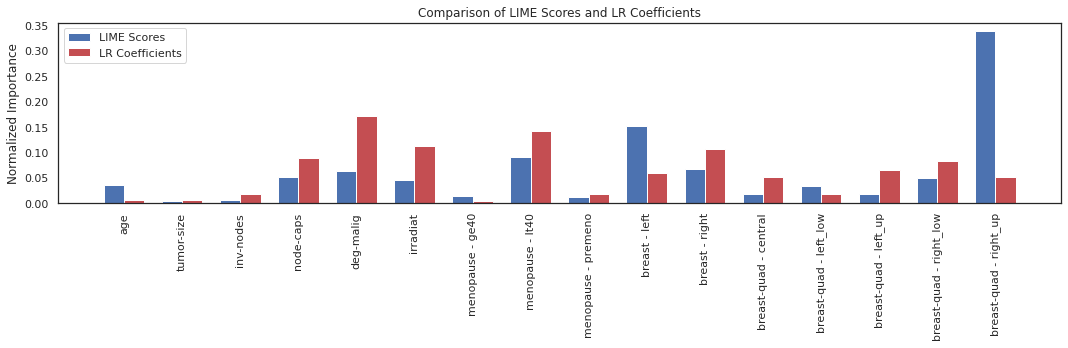

In [21]:
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Initialize LIME explainer
explainer = LimeTabularExplainer(X, mode='classification', feature_names=cols, class_names=df['recurrence'].unique().tolist())

# Aggregate LIME importance scores
lime_scores = np.zeros(X.shape[1])

for i in range(X.shape[0]):
    exp = explainer.explain_instance(X[i], clf_lr.predict_proba, num_features=X.shape[1])
    for feature, score in exp.as_list():
        # Extract the base feature name from the LIME explanation
        base_feature_name = feature.split(' <= ')[0].split(' > ')[0]
        if base_feature_name in cols:
            feature_idx = cols.index(base_feature_name)
            lime_scores[feature_idx] += np.abs(score)  # We consider the absolute value for aggregation

# Normalize LIME scores and LR coefficients for comparison
lime_scores_normalized = lime_scores / np.sum(lime_scores)
lr_coef_normalized = np.abs(clf_lr.coef_[0]) / np.sum(np.abs(clf_lr.coef_[0]))  # We consider the absolute value of coefficients

# Plotting
plt.figure(figsize=(15, 5))
x = np.arange(len(cols))
width = 0.35

plt.bar(x - width/2, lime_scores_normalized, width, label='LIME Scores', color='b')
plt.bar(x + width/2, lr_coef_normalized, width, label='LR Coefficients', color='r')

plt.xticks(x, cols, rotation=90)
plt.ylabel('Normalized Importance')
plt.title('Comparison of LIME Scores and LR Coefficients')
plt.legend()

plt.tight_layout()
plt.show()


Conclusion: As you can LIME scores do not align with LR score. Hence we can conclude that LIME results does not support LR feature ranking

Exercise 2. According to LIME which classifier is more robust in newsgroups problem?



Ans: After lookinmg at output of both explainer, the first explainer (for svc) seems to be more robust than the second one (for random forest) . This si because the second algorithm highlights 5 stop words like in, but , whatm, Re etc in a gorup of 7 words. These 5 words do not convey any semantic meaning. The first algorith, highlights important words like Shaft and people names Winona, Stafford, do with very little noise. The explanation for miscelleneous and parts and [people names does more sound logical for miscellenous sale category as compared to explainer for explainer 2.

Exercise 3. Why is that the correlation between Recurrence and Age is reddish (as opposed to blueish)?



Exercise 4. Determine a rule with 'ts_large' and find out its highest support and confidence.


[50 pts] Build a model for the MNIST dataset provided in the module. Use LIME image
explainer LimeImageExplainer to find out how digits are predicted. Plot one good example
explanation figure for every digit 0 to 9. Note that you can use any model as you see fit
(algorithms from sklearn are the easiest). CNN (PyTorch) models are recommended to achieve
almost perfect learning.
Do you need to setup a training and testing set? Note that one could use regularization, robust
CNN, and dropout to achieve non-overfitting on reclassification.
Comment on results. Are there any specific patterns discriminating certain digits?
2. [50 pts] Rework on the MovieLens dataset to determine a set of 19 tags that explains one
of the 19 Genres while having an inert relation with the rest of the genres. Clearly, we
should not use the genre term itself. And those 19 terms must encompass the genres. An
example would be the term cowboy for Western movies.
The set of the tags can come from the movielens_genome_tags.csv. However, you are free
to use GloVe or any other vocabulary source that explains the genre. If one uses a
particular approach to determine terms (with max-score to genre and min-scores to the
rest) then all 19 terms must be discovered in that manner.
(Hint: A sort function with 19 components where each component could be the distance to
the genre might work, such as, cost = -g1 + g2 + g3 + ... + g19) where g is the distance and
cost is minimized for genre 1).
Note that you can approach this problem in any way you like. Above steps are just
guidance.
